# Task 1 (DeepLense): Substructure Classification
### Chenguang Guan

## I. Preparation

In [1]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [10]:
!unzip /content/gdrive/MyDrive/dataset.zip 

Streaming output truncated to the last 5000 lines.
  inflating: dataset/val/no/531.npy  
  inflating: dataset/val/no/257.npy  
  inflating: dataset/val/no/243.npy  
  inflating: dataset/val/no/525.npy  
  inflating: dataset/val/no/1099.npy  
  inflating: dataset/val/no/1927.npy  
  inflating: dataset/val/no/1933.npy  
  inflating: dataset/val/no/519.npy  
  inflating: dataset/val/no/1066.npy  
  inflating: dataset/val/no/1700.npy  
  inflating: dataset/val/no/294.npy  
  inflating: dataset/val/no/2209.npy  
  inflating: dataset/val/no/280.npy  
  inflating: dataset/val/no/1714.npy  
  inflating: dataset/val/no/1072.npy  
  inflating: dataset/val/no/2235.npy  
  inflating: dataset/val/no/1728.npy  
  inflating: dataset/val/no/2221.npy  
  inflating: dataset/val/no/733.npy  
  inflating: dataset/val/no/727.npy  
  inflating: dataset/val/no/1502.npy  
  inflating: dataset/val/no/1264.npy  
  inflating: dataset/val/no/928.npy  
  inflating: dataset/val/no/1270.npy  
  inflating: dataset/va

In [1]:
import numpy as np
import glob
import os

import torch
from torch.utils.data import Dataset, DataLoader

import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision.transforms as transforms

import random
import time


from sklearn import metrics

import matplotlib.pyplot as plt

In [2]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device is:", device)

Device is: cuda


## II. Dataset

In [4]:
DATASET_PATH = '/content/dataset'

### Memory-saving Way

In [8]:
class MyDataset(Dataset):
    def __init__(self, dataset_dir, train = True, transform = None, target_transform = None):
        self.dataset_dir = dataset_dir
        self.train = train
        self.transform = transform
        self.target_transform = target_transform

        self.path_list = list()
        if train:
            dataset_dir = os.path.join(dataset_dir, "train")
        else:
            dataset_dir = os.path.join(dataset_dir, "val")
        for dataset_class in ["no", "sphere", "vort"]:
            subdir = os.path.join(dataset_dir, dataset_class) + "/"
            self.path_list += list(glob.glob(subdir + "*.npy") )
            
    def __len__(self):
        return len(self.path_list)
    
    def __getitem__(self,idx):
        image = torch.from_numpy( np.load( self.path_list[idx] ).astype(np.float32) )
        if idx < len(self.path_list)/3:
            label = 0
        elif len(self.path_list)/3 <= idx < len(self.path_list)*2/3:
            label = 1
        else:
            label = 2
        
        if self.transform:
            image = self.transform( image )
        if self.target_transform:
            label = self.target_transform( label )
        return image, label 

### Faster Way

In [3]:
def dataset_path_list(dataset_dir, train=True):
    path_list = list()
    if train:
        dir_type = "train"
    else:
        dir_type = "val"
    dataset_dir = os.path.join(dataset_dir, dir_type)
    for dataset_class in ["no", "sphere", "vort"]:
        subdir = os.path.join(dataset_dir, dataset_class) + "/"
        path_list += list(glob.glob(subdir + "*.npy") )
    return path_list

In [4]:
def dataset_list(dataset_dir, train=True):
    data_list = list()
    for each_path in dataset_path_list(dataset_dir, train):
        data_list.append( np.load( each_path ).astype(np.float32) )
    return data_list

In [ ]:
train_X_list = dataset_list(DATASET_PATH, train=True)
test_X_list = dataset_list(DATASET_PATH, train=False)

In [27]:
np.save("/content/gdrive/MyDrive/DeepLense_data/train_X.npy", train_X_list )
np.save("/content/gdrive/MyDrive/DeepLense_data/test_X.npy", test_X_list )

In [38]:
train_X_list = np.load("/content/gdrive/MyDrive/DeepLense_data/train_X.npy")
test_X_list = np.load( "/content/gdrive/MyDrive/DeepLense_data/test_X.npy" )

In [39]:
train_X_list = np.array(train_X_list)
test_X_list = np.array(test_X_list)

In [40]:
train_X_list = np.tile(train_X_list, (1, 3, 1, 1))
test_X_list = np.tile(test_X_list, (1, 3, 1, 1))

In [6]:
train_y_list = [0] * 10000 + [1] * 10000 + [2] * 10000
test_y_list = [0] * 2500 + [1] * 2500 + [2] * 2500

In [36]:
class MyDataset(Dataset):
    def __init__(self, train = True, transform = None, target_transform = None):
        global train_X_list, train_y_list
        global test_X_list, test_y_list
        self.train = train
        self.transform = transform
        self.target_transform = target_transform
            
    def __len__(self):
        if self.train:
            return 30000
        else:
            return 7500
    
    def __getitem__(self,idx):
        if self.train:
            image, label = torch.from_numpy( train_X_list[idx] ), train_y_list[idx]
        else:
            image, label = torch.from_numpy( test_X_list[idx] ), test_y_list[idx]
        
        if self.transform:
            image = self.transform( image )
        if self.target_transform:
            label = self.target_transform( label )
        return image, label 

### Dataset and Dataloader

In [8]:
my_transform_pretrained = transforms.Resize((224,224))
my_transform_single_channel = transforms.Compose([transforms.Resize((224, 224)),
                                   transforms.Lambda(lambda x: x.repeat(3, 1, 1) )
    ])

In [7]:
train_set = MyDataset(train=True)
test_set = MyDataset(train=False)
train_loader = DataLoader(train_set, batch_size=500, shuffle=True)
test_loader = DataLoader(test_set, batch_size=500, shuffle=False)

### Data Augmentation

In [9]:
my_transform_augmentation = transforms.Compose( [transforms.RandomRotation(degrees=90), transforms.Resize((224, 224))] )


### Plot of Data

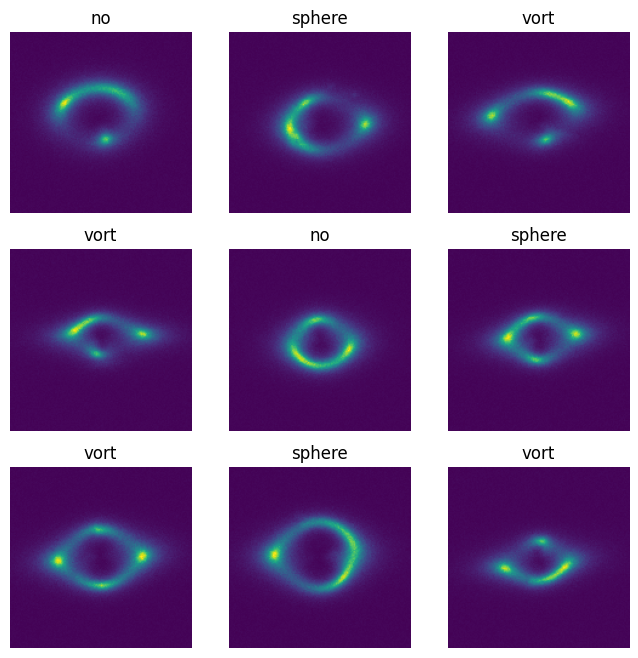

In [8]:
import matplotlib.pyplot as plt
labels_map = {
    0: "no",
    1: "sphere",
    2: "vort"
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_set), size=(1,)).item()
    img, label = train_set[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze())
plt.show()

## III. Train and Test Loop

In [10]:
criterion = nn.CrossEntropyLoss()

In [11]:
def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()
    
    size = len(dataloader.dataset)
    running_loss = 0.
    #total_sample = 0
    for batch_i, data in enumerate(dataloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # Compute prediction and loss
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        num_batch_print = 50
        if batch_i % num_batch_print == num_batch_print - 1:
            current = (batch_i + 1) * len(inputs)
            print(f'batch: [{batch_i + 1:5d}], loss: {running_loss / num_batch_print:.3f}')
            print(f'temporary loss: {loss.item():>7f} | [{current:>5d}/{size:>5d}]')
            running_loss = 0

In [12]:
def test_loop_Entropy(dataloader, model, loss_fn):
    model.eval()
    #size = len(dataloader.dataset)
    num_batches = len(dataloader)
    
    test_loss, correct = 0, 0
    total = 0
    
    with torch.no_grad():
        for data in dataloader:
            # get the inputs for test dataset
            images, labels = data[0].to(device), data[1].to(device)
            
            # calculate the outputs
            outputs = model(images)
            
            # classify which class the output in
            _, predicted = torch.max(outputs.data, 1)
            #_, labels_value = torch.max(labels.data, 1)
            
            # obtain the statistics of test loss and correctness
            test_loss += loss_fn(outputs, labels).item()
            correct += (predicted == labels).sum().item() 
            #correct += (predicted == labels_value).sum().item() 
            total += labels.size(0)

    print(f"Test Error: \n Accuracy: {(100 * correct / total):>0.1f}%")
    print(f"Avg loss: {test_loss / num_batches:>8f} \n")
    
    return test_loss / num_batches

In [13]:
def test_loop_prob(dataloader, model, class_i):
    model.eval()
    #size = len(dataloader.dataset)
    num_batches = len(dataloader)
    
    total_prob = list()
    total_label = list()
    i = 0
    with torch.no_grad():
        for (i, data) in enumerate(dataloader):
            # get the inputs for test dataset
            images, labels = data[0].to(device), data[1].to(device)
            
            # calculate the outputs
            outputs = model(images)
            probabilities = F.softmax(outputs, dim=1)[:, class_i]
            
            total_prob += torch.Tensor.cpu(probabilities).numpy().tolist()
            
            total_label += torch.Tensor.cpu(labels==class_i).numpy().tolist()
            
            if i % 25 == 0:
                print(f"Process: {i/num_batches*100}\%")
    return np.array(total_prob), np.array(total_label)

## IV. Pre-trained ResNet-18

1. GPU: A100
2. Learning Rates: 1e-4 (10 epochs), 1e-5 (5 epochs), 1e-6 (5 epochs)
3. Data Augmentation: Random rotations up to 90 degrees
4. Accuracy: 92.6%
5. ROC-AUC score (three classes): 0.98-0.99

In [22]:
train_set = MyDataset(train=True, transform=my_transform_augmentation)
train_loader =  DataLoader(train_set, batch_size=200, shuffle=True)

In [23]:
train_set_not_aug = MyDataset(train=True, transform=my_transform_pretrained)
train_loader_not_aug =  DataLoader(train_set_not_aug, batch_size=200, shuffle=False)

In [24]:
test_set = MyDataset(train=False, transform=my_transform_pretrained)
test_loader =  DataLoader(test_set, batch_size=200, shuffle=False)

In [25]:
# Pre-trained ResNet18
model_ResNet18 = torchvision.models.resnet18(pretrained=True).to(device)
in_features = model_ResNet18.fc.in_features
model_ResNet18.fc = nn.Linear(in_features, 3, device=device)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [26]:
lr_list = [1e-4] * 10 + [1e-5] * 5 + [1e-6] * 5
time_start = time.time()
# Pre-trained ResNet training
for t in range( len(lr_list) ):
    print(f"-------------Epoch {t+1}-------------")
    #optimizer = optim.SGD(model.parameters(), lr=lr_list[t], momentum=0.9)
    optimizer = optim.Adam(model_ResNet18.parameters(), lr=lr_list[t])
    train_loop(train_loader, model_ResNet18, criterion, optimizer)
    print("Train Set")
    test_loop_Entropy(train_loader_not_aug, model_ResNet18, criterion)
    print("Test Set")
    test_loop_Entropy(test_loader, model_ResNet18, criterion)
print("Done!")
time_end = time.time()
print("Time Consumption",time_end-time_start)

-------------Epoch 1-------------
batch: [   50], loss: 1.120
temporary loss: 1.115036 | [10000/30000]
batch: [  100], loss: 1.065
temporary loss: 0.973463 | [20000/30000]
batch: [  150], loss: 0.960
temporary loss: 0.896022 | [30000/30000]
Train Set
Test Error: 
 Accuracy: 59.7%
Avg loss: 0.893639 

Test Set
Test Error: 
 Accuracy: 58.4%
Avg loss: 0.899993 

-------------Epoch 2-------------
batch: [   50], loss: 0.817
temporary loss: 0.816832 | [10000/30000]
batch: [  100], loss: 0.698
temporary loss: 0.677159 | [20000/30000]
batch: [  150], loss: 0.631
temporary loss: 0.610978 | [30000/30000]
Train Set
Test Error: 
 Accuracy: 74.4%
Avg loss: 0.583621 

Test Set
Test Error: 
 Accuracy: 73.5%
Avg loss: 0.599284 

-------------Epoch 3-------------
batch: [   50], loss: 0.584
temporary loss: 0.504043 | [10000/30000]
batch: [  100], loss: 0.536
temporary loss: 0.521678 | [20000/30000]
batch: [  150], loss: 0.516
temporary loss: 0.419679 | [30000/30000]
Train Set
Test Error: 
 Accuracy: 8

In [27]:
path = "./gdrive/MyDrive/DeepLense_model/DeepLense_task1_ResNet_weights_01.pth"
torch.save(model_ResNet18.state_dict(), path)

### ROC-AUC of Class 0: "no"

In [31]:
total_prob_ResNet18, total_label_ResNet18 = test_loop_prob(test_loader, model_ResNet18, class_i=0)
fpr, tpr, thresholds = metrics.roc_curve(total_label_ResNet18, total_prob_ResNet18)
ResNet18_AUC_1 = metrics.roc_auc_score(total_label_ResNet18, total_prob_ResNet18)

Process: 0.0\%
Process: 65.78947368421053\%


In [32]:
print("The ROC-AUC score of Pre-trained ResNet-18 (no) is:", ResNet18_AUC_1)

The ROC-AUC score of Pre-trained ResNet-18 (no) is: 0.98869736


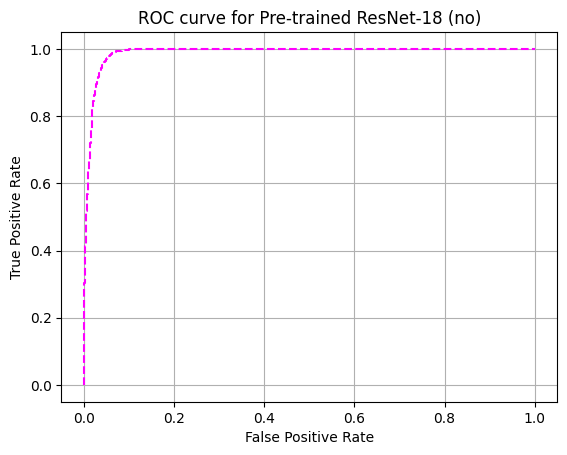

In [35]:
plt.plot(fpr, tpr, "--", color="magenta")
#plt.plot([0,1],[0,1],"--")
plt.grid()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve for Pre-trained ResNet-18 (no)")
plt.show()

### ROC-AUC of Class 1: "vort"

In [39]:
total_prob_ResNet18, total_label_ResNet18 = test_loop_prob(test_loader, model_ResNet18, class_i=1)
fpr, tpr, thresholds = metrics.roc_curve(total_label_ResNet18, total_prob_ResNet18)
ResNet18_AUC_1 = metrics.roc_auc_score(total_label_ResNet18, total_prob_ResNet18)

Process: 0.0\%
Process: 65.78947368421053\%


In [40]:
print("The ROC-AUC score of Pre-trained ResNet-18 (vort) is:", ResNet18_AUC_1)

The ROC-AUC score of Pre-trained ResNet-18 (vort) is: 0.9781550400000001


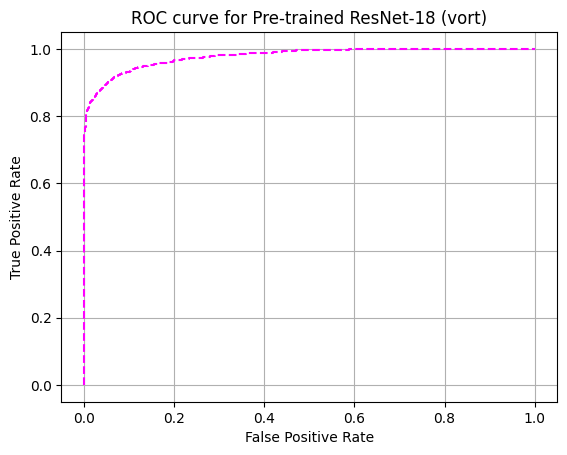

In [41]:
plt.plot(fpr, tpr, "--", color="magenta")
#plt.plot([0,1],[0,1],"--")
plt.grid()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve for Pre-trained ResNet-18 (vort)")
plt.show()

### ROC-AUC of Class 2: "sphere"

In [42]:
total_prob_ResNet18, total_label_ResNet18 = test_loop_prob(test_loader, model_ResNet18, class_i=2)
fpr, tpr, thresholds = metrics.roc_curve(total_label_ResNet18, total_prob_ResNet18)
ResNet18_AUC_1 = metrics.roc_auc_score(total_label_ResNet18, total_prob_ResNet18)

Process: 0.0\%
Process: 65.78947368421053\%


In [43]:
print("The ROC-AUC score of Pre-trained ResNet-18 (sphere) is:", ResNet18_AUC_1)

The ROC-AUC score of Pre-trained ResNet-18 (sphere) is: 0.9925437599999999


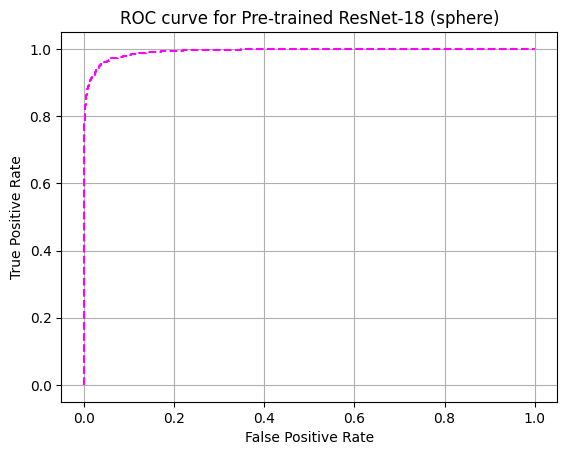

In [44]:
plt.plot(fpr, tpr, "--", color="magenta")
#plt.plot([0,1],[0,1],"--")
plt.grid()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve for Pre-trained ResNet-18 (sphere)")
plt.show()

## V. Pre-trained VGG
1. GPU: A100
2. Learning Rates: 1e-5 (initial learning rate)
3. Data Augmentation: Random rotations up to 90 degrees
4. Accuracy: 76.9% (underfit)

When the learning-rate is 1e-4, the model can not learn anything. Therefore, the learning rate should be less than 1e-4.

The VGG-16 model is much more difficult to train. After 25 Epochs, the accuracy is 76.9% (much less than ResNet after same number of epochs).



In [14]:
train_set = MyDataset(train=True, transform=my_transform_augmentation)
train_loader =  DataLoader(train_set, batch_size=200, shuffle=True)

In [15]:
train_set_not_aug = MyDataset(train=True, transform=my_transform_pretrained)
train_loader_not_aug =  DataLoader(train_set_not_aug, batch_size=200, shuffle=False)

In [16]:
test_set = MyDataset(train=False, transform=my_transform_pretrained)
test_loader =  DataLoader(test_set, batch_size=200, shuffle=False)

In [19]:
model_VGG16 = torchvision.models.vgg16(weights=torchvision.models.VGG16_Weights.IMAGENET1K_V1).to(device)
in_features = model_VGG16.classifier[6].in_features
model_VGG16.classifier[6] = nn.Linear(in_features, 3, device=device)

In [20]:
lr_list = [1e-5] * 5
time_start = time.time()
# Pre-trained ResNet training
for t in range( len(lr_list) ):
    print(f"-------------Epoch {t+1}-------------")
    #optimizer = optim.SGD(model.parameters(), lr=lr_list[t], momentum=0.9)
    optimizer = optim.Adam(model_VGG16.parameters(), lr=lr_list[t])
    train_loop(train_loader, model_VGG16, criterion, optimizer)
    print("Train Set")
    test_loop_Entropy(train_loader_not_aug, model_VGG16, criterion)
    print("Test Set")
    test_loop_Entropy(test_loader, model_VGG16, criterion)
print("Done!")
time_end = time.time()
print("Time Consumption",time_end-time_start)

-------------Epoch 1-------------
batch: [   50], loss: 1.110
temporary loss: 1.099146 | [10000/30000]
batch: [  100], loss: 1.096
temporary loss: 1.085552 | [20000/30000]
batch: [  150], loss: 1.087
temporary loss: 1.086202 | [30000/30000]
Train Set
Test Error: 
 Accuracy: 37.8%
Avg loss: 1.082713 

Test Set
Test Error: 
 Accuracy: 38.2%
Avg loss: 1.084438 

-------------Epoch 2-------------
batch: [   50], loss: 1.071
temporary loss: 1.065882 | [10000/30000]
batch: [  100], loss: 1.061
temporary loss: 1.020093 | [20000/30000]
batch: [  150], loss: 1.032
temporary loss: 1.012576 | [30000/30000]
Train Set
Test Error: 
 Accuracy: 39.6%
Avg loss: 1.101848 

Test Set
Test Error: 
 Accuracy: 39.1%
Avg loss: 1.106949 

-------------Epoch 3-------------
batch: [   50], loss: 1.015
temporary loss: 1.008376 | [10000/30000]
batch: [  100], loss: 0.979
temporary loss: 0.951283 | [20000/30000]
batch: [  150], loss: 0.963
temporary loss: 0.927361 | [30000/30000]
Train Set
Test Error: 
 Accuracy: 4

In [21]:
lr_list = [1e-5] * 5 + [1e-6] * 5
time_start = time.time()
# Pre-trained ResNet training
for t in range( len(lr_list) ):
    print(f"-------------Epoch {t+1}-------------")
    #optimizer = optim.SGD(model.parameters(), lr=lr_list[t], momentum=0.9)
    optimizer = optim.Adam(model_VGG16.parameters(), lr=lr_list[t])
    train_loop(train_loader, model_VGG16, criterion, optimizer)
    print("Train Set")
    test_loop_Entropy(train_loader_not_aug, model_VGG16, criterion)
    print("Test Set")
    test_loop_Entropy(test_loader, model_VGG16, criterion)
print("Done!")
time_end = time.time()
print("Time Consumption",time_end-time_start)

-------------Epoch 1-------------
batch: [   50], loss: 0.843
temporary loss: 0.906187 | [10000/30000]
batch: [  100], loss: 0.833
temporary loss: 0.795496 | [20000/30000]
batch: [  150], loss: 0.824
temporary loss: 0.817618 | [30000/30000]
Train Set
Test Error: 
 Accuracy: 57.0%
Avg loss: 0.858592 

Test Set
Test Error: 
 Accuracy: 57.2%
Avg loss: 0.858227 

-------------Epoch 2-------------
batch: [   50], loss: 0.820
temporary loss: 0.860686 | [10000/30000]
batch: [  100], loss: 0.788
temporary loss: 0.776059 | [20000/30000]
batch: [  150], loss: 0.763
temporary loss: 0.672102 | [30000/30000]
Train Set
Test Error: 
 Accuracy: 63.2%
Avg loss: 0.772768 

Test Set
Test Error: 
 Accuracy: 62.5%
Avg loss: 0.780924 

-------------Epoch 3-------------
batch: [   50], loss: 0.781
temporary loss: 0.743465 | [10000/30000]
batch: [  100], loss: 0.752
temporary loss: 0.841541 | [20000/30000]
batch: [  150], loss: 0.751
temporary loss: 0.704947 | [30000/30000]
Train Set
Test Error: 
 Accuracy: 6

In [22]:
lr_list = [1e-5] * 10
time_start = time.time()
# Pre-trained ResNet training
for t in range( len(lr_list) ):
    print(f"-------------Epoch {t+1}-------------")
    #optimizer = optim.SGD(model.parameters(), lr=lr_list[t], momentum=0.9)
    optimizer = optim.Adam(model_VGG16.parameters(), lr=lr_list[t])
    train_loop(train_loader, model_VGG16, criterion, optimizer)
    print("Train Set")
    test_loop_Entropy(train_loader_not_aug, model_VGG16, criterion)
    print("Test Set")
    test_loop_Entropy(test_loader, model_VGG16, criterion)
print("Done!")
time_end = time.time()
print("Time Consumption",time_end-time_start)

-------------Epoch 1-------------
batch: [   50], loss: 0.678
temporary loss: 0.673767 | [10000/30000]
batch: [  100], loss: 0.658
temporary loss: 0.608032 | [20000/30000]
batch: [  150], loss: 0.671
temporary loss: 0.714985 | [30000/30000]
Train Set
Test Error: 
 Accuracy: 70.6%
Avg loss: 0.648709 

Test Set
Test Error: 
 Accuracy: 69.1%
Avg loss: 0.665073 

-------------Epoch 2-------------
batch: [   50], loss: 0.654
temporary loss: 0.678092 | [10000/30000]
batch: [  100], loss: 0.647
temporary loss: 0.627564 | [20000/30000]
batch: [  150], loss: 0.656
temporary loss: 0.705543 | [30000/30000]
Train Set
Test Error: 
 Accuracy: 71.4%
Avg loss: 0.637485 

Test Set
Test Error: 
 Accuracy: 70.1%
Avg loss: 0.654295 

-------------Epoch 3-------------
batch: [   50], loss: 0.651
temporary loss: 0.671596 | [10000/30000]
batch: [  100], loss: 0.643
temporary loss: 0.578128 | [20000/30000]
batch: [  150], loss: 0.639
temporary loss: 0.670689 | [30000/30000]
Train Set
Test Error: 
 Accuracy: 7

In [23]:
path = "./gdrive/MyDrive/DeepLense_model/DeepLense_task1_VGG_weights_01.pth"
torch.save(model_VGG16.state_dict(), path)

## VI. Pre-trianed AlexNet

1. GPU: A100
2. Learning Rates: 1e-4 (10 epochs), 1e-5 (5 epochs), 1e-6 (5 epochs)
3. Data Augmentation: Random rotations up to 90 degrees

The AlexNet is also very hard to train on this dataset.

When the initial rate is 1e-4 or 1e-5 or 1e-6, the model still can not learn anything (the accuracy after 5 epochs is about 1/3).

In [25]:
model_alex = torchvision.models.alexnet(weights=torchvision.models.AlexNet_Weights.IMAGENET1K_V1).to(device)
in_features = model_alex.classifier[6].in_features
model_alex.classifier[6]= nn.Linear(in_features, 3, device=device)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [26]:
lr_list = [1e-6] * 5
time_start = time.time()
# Pre-trained ResNet training
for t in range( len(lr_list) ):
    print(f"-------------Epoch {t+1}-------------")
    #optimizer = optim.SGD(model.parameters(), lr=lr_list[t], momentum=0.9)
    optimizer = optim.Adam(model_alex.parameters(), lr=lr_list[t])
    train_loop(train_loader, model_alex, criterion, optimizer)
    print("Train Set")
    test_loop_Entropy(train_loader_not_aug, model_alex, criterion)
    print("Test Set")
    test_loop_Entropy(test_loader, model_alex, criterion)
print("Done!")
time_end = time.time()
print("Time Consumption",time_end-time_start)

-------------Epoch 1-------------
batch: [   50], loss: 1.113
temporary loss: 1.086285 | [10000/30000]
batch: [  100], loss: 1.111
temporary loss: 1.120393 | [20000/30000]
batch: [  150], loss: 1.110
temporary loss: 1.109806 | [30000/30000]
Train Set
Test Error: 
 Accuracy: 33.2%
Avg loss: 1.101196 

Test Set
Test Error: 
 Accuracy: 33.7%
Avg loss: 1.100852 

-------------Epoch 2-------------
batch: [   50], loss: 1.109
temporary loss: 1.112774 | [10000/30000]
batch: [  100], loss: 1.107
temporary loss: 1.116270 | [20000/30000]
batch: [  150], loss: 1.107
temporary loss: 1.101467 | [30000/30000]
Train Set
Test Error: 
 Accuracy: 33.2%
Avg loss: 1.099969 

Test Set
Test Error: 
 Accuracy: 33.7%
Avg loss: 1.099912 

-------------Epoch 3-------------
batch: [   50], loss: 1.107
temporary loss: 1.129694 | [10000/30000]
batch: [  100], loss: 1.104
temporary loss: 1.090893 | [20000/30000]
batch: [  150], loss: 1.104
temporary loss: 1.120479 | [30000/30000]
Train Set
Test Error: 
 Accuracy: 3

## VII. Further Discussion (non-pretrained models)

I also try some non-pretrained simple models, such as MLP, LeNet, and Simple ResNet with two blocks. However, Their performance is poor.

In [41]:
train_X_list = train_X_list[:, :1, :, :]
test_X_list = test_X_list[:, :1, :, :]

In [28]:
my_transform_aug_simple = transforms.RandomRotation(degrees=90)

In [29]:
train_set = MyDataset(train=True, transform=my_transform_aug_simple)
train_loader =  DataLoader(train_set, batch_size=200, shuffle=True)

In [30]:
train_set_not_aug = MyDataset(train=True)
train_loader_not_aug =  DataLoader(train_set_not_aug, batch_size=200, shuffle=False)

In [31]:
test_set = MyDataset(train=False)
test_loader =  DataLoader(test_set, batch_size=200, shuffle=False)

### MLP

In [44]:
class Naive_NN(nn.Module):

    def __init__(self):
        super(Naive_NN, self).__init__()
        
        self.fc1 = nn.Linear(150 * 150, 2250) 
        self.fc2 = nn.Linear(2250, 10) 

    def forward(self, x):
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

In [45]:
model_MLP = Naive_NN().to(device)

In [46]:
lr_list = [1e-4] * 5
time_start = time.time()
for t in range( len(lr_list) ):
    print(f"-------------Epoch {t+1}-------------")
    #optimizer = optim.SGD(model.parameters(), lr=lr_list[t], momentum=0.9)
    optimizer = optim.Adam(model_MLP.parameters(), lr=lr_list[t])
    train_loop(train_loader, model_MLP, criterion, optimizer)
    print("Train Set")
    test_loop_Entropy(train_loader_not_aug, model_MLP, criterion)
    print("Test Set")
    test_loop_Entropy(test_loader, model_MLP, criterion)
print("Done!")
time_end = time.time()
print("Time Consumption",time_end-time_start)

-------------Epoch 1-------------
batch: [   50], loss: 1.165
temporary loss: 1.121556 | [10000/30000]
batch: [  100], loss: 1.124
temporary loss: 1.098567 | [20000/30000]
batch: [  150], loss: 1.113
temporary loss: 1.140422 | [30000/30000]
Train Set
Test Error: 
 Accuracy: 34.2%
Avg loss: 1.109183 

Test Set
Test Error: 
 Accuracy: 33.4%
Avg loss: 1.111960 

-------------Epoch 2-------------
batch: [   50], loss: 1.120
temporary loss: 1.108835 | [10000/30000]
batch: [  100], loss: 1.111
temporary loss: 1.120244 | [20000/30000]
batch: [  150], loss: 1.111
temporary loss: 1.110422 | [30000/30000]
Train Set
Test Error: 
 Accuracy: 33.9%
Avg loss: 1.111816 

Test Set
Test Error: 
 Accuracy: 33.6%
Avg loss: 1.115428 

-------------Epoch 3-------------
batch: [   50], loss: 1.142
temporary loss: 1.129392 | [10000/30000]
batch: [  100], loss: 1.109
temporary loss: 1.089984 | [20000/30000]
batch: [  150], loss: 1.112
temporary loss: 1.089526 | [30000/30000]
Train Set
Test Error: 
 Accuracy: 3

### CNN (LeNet type)

In [32]:
class CNN_lense(nn.Module):

    def __init__(self):
        super(CNN_lense, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 2, 5)
        self.conv2 = nn.Conv2d(2, 4, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(4 * 34 * 34, 800)  # 5*5 from image dimension
        self.fc2 = nn.Linear(800, 150)
        self.fc3 = nn.Linear(150, 3)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square, you can specify with a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [33]:
model_CNN = CNN_lense().to(device)

In [43]:
lr_list = [1e-4] * 5
time_start = time.time()
for t in range( len(lr_list) ):
    print(f"-------------Epoch {t+1}-------------")
    #optimizer = optim.SGD(model.parameters(), lr=lr_list[t], momentum=0.9)
    optimizer = optim.Adam(model_CNN.parameters(), lr=lr_list[t])
    train_loop(train_loader, model_CNN, criterion, optimizer)
    print("Train Set")
    test_loop_Entropy(train_loader_not_aug, model_CNN, criterion)
    print("Test Set")
    test_loop_Entropy(test_loader, model_CNN, criterion)
print("Done!")
time_end = time.time()
print("Time Consumption",time_end-time_start)

-------------Epoch 1-------------
batch: [   50], loss: 1.099
temporary loss: 1.097940 | [10000/30000]
batch: [  100], loss: 1.099
temporary loss: 1.098534 | [20000/30000]
batch: [  150], loss: 1.099
temporary loss: 1.098831 | [30000/30000]
Train Set
Test Error: 
 Accuracy: 33.3%
Avg loss: 1.098715 

Test Set
Test Error: 
 Accuracy: 33.3%
Avg loss: 1.098974 

-------------Epoch 2-------------
batch: [   50], loss: 1.099
temporary loss: 1.100206 | [10000/30000]
batch: [  100], loss: 1.099
temporary loss: 1.098801 | [20000/30000]
batch: [  150], loss: 1.099
temporary loss: 1.098326 | [30000/30000]
Train Set
Test Error: 
 Accuracy: 33.4%
Avg loss: 1.098714 

Test Set
Test Error: 
 Accuracy: 33.3%
Avg loss: 1.098989 

-------------Epoch 3-------------
batch: [   50], loss: 1.099
temporary loss: 1.098043 | [10000/30000]
batch: [  100], loss: 1.099
temporary loss: 1.100161 | [20000/30000]
batch: [  150], loss: 1.099
temporary loss: 1.098671 | [30000/30000]
Train Set
Test Error: 
 Accuracy: 3

### Simplified ResNet (two blocks)

In [47]:
class ResBlock(torch.nn.Module):
    def __init__(self,channels_in):
        super().__init__()
        self.conv1=torch.nn.Conv2d(channels_in,30,5,padding=2)
        self.conv2=torch.nn.Conv2d(30,channels_in,3,padding=1)

    def forward(self,x):
        out=self.conv1(x)
        out=self.conv2(out)
        return F.relu(out+x)

In [48]:
class ResNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1=torch.nn.Conv2d(1,20,5)
        self.conv2=torch.nn.Conv2d(20,15,3)
        self.maxpool=torch.nn.MaxPool2d(2)
        self.resblock1=ResBlock(channels_in=20)
        self.resblock2=ResBlock(channels_in=15)
        self.full_c=torch.nn.Linear(15*35*35,3)

    def forward(self,x):
        size=x.shape[0]
        x=F.relu(self.maxpool(self.conv1(x)))
        x=self.resblock1(x)
        x=F.relu(self.maxpool(self.conv2(x)))
        x=self.resblock2(x)
        x=x.view(size,-1)
        x=self.full_c(x)
        return x

In [49]:
model_ResNet = ResNet().to(device)

In [50]:
lr_list = [1e-4] * 5
time_start = time.time()
for t in range( len(lr_list) ):
    print(f"-------------Epoch {t+1}-------------")
    #optimizer = optim.SGD(model.parameters(), lr=lr_list[t], momentum=0.9)
    optimizer = optim.Adam(model_ResNet.parameters(), lr=lr_list[t])
    train_loop(train_loader, model_ResNet, criterion, optimizer)
    print("Train Set")
    test_loop_Entropy(train_loader_not_aug, model_ResNet, criterion)
    print("Test Set")
    test_loop_Entropy(test_loader, model_ResNet, criterion)
print("Done!")
time_end = time.time()
print("Time Consumption",time_end-time_start)

-------------Epoch 1-------------
batch: [   50], loss: 1.099
temporary loss: 1.098688 | [10000/30000]
batch: [  100], loss: 1.099
temporary loss: 1.099142 | [20000/30000]
batch: [  150], loss: 1.099
temporary loss: 1.099377 | [30000/30000]
Train Set
Test Error: 
 Accuracy: 33.3%
Avg loss: 1.098650 

Test Set
Test Error: 
 Accuracy: 33.3%
Avg loss: 1.098588 

-------------Epoch 2-------------
batch: [   50], loss: 1.099
temporary loss: 1.098193 | [10000/30000]
batch: [  100], loss: 1.099
temporary loss: 1.099562 | [20000/30000]
batch: [  150], loss: 1.099
temporary loss: 1.098014 | [30000/30000]
Train Set
Test Error: 
 Accuracy: 34.3%
Avg loss: 1.098439 

Test Set
Test Error: 
 Accuracy: 34.3%
Avg loss: 1.098565 

-------------Epoch 3-------------
batch: [   50], loss: 1.098
temporary loss: 1.098199 | [10000/30000]
batch: [  100], loss: 1.098
temporary loss: 1.098736 | [20000/30000]
batch: [  150], loss: 1.098
temporary loss: 1.096615 | [30000/30000]
Train Set
Test Error: 
 Accuracy: 3